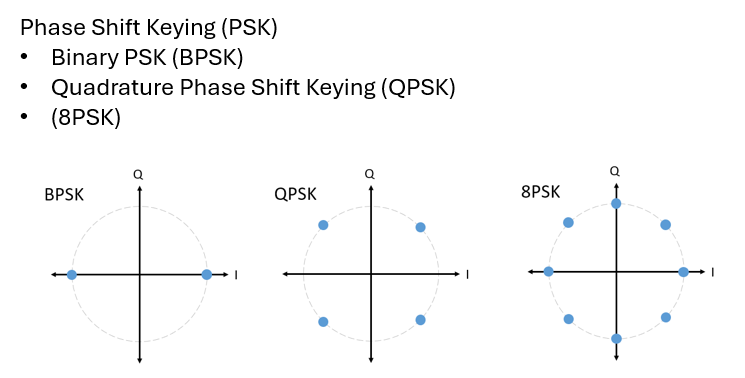

# **QPSK**

# 0. Librerie e parametri iniziali

In [1]:
"""
Created on: Mon Nov 18 12:47:27 2024
Last modified: Tue Nov 26 14:14 2024
@author: giovanni bolla
"""
# from IPython import get_ipython
# from IPython.display import display
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc


plt.close('all')

In [2]:
# Parametri iniziali (esempio, puoi sostituirli con i tuoi valori)
num_subplots = 11  # Numero di subplot, corrispondente a len(Eb_N0_dB)
cols = 3           # Numero di colonne nei subplot
rows = int(np.ceil(num_subplots / cols))  # Numero di righe necessario

Eb_N0_dB = np.arange(0, 21, 2)  # da 0 a 20 con passo di 2 = 11 elementi che esprimono il contrasto di energia in dB  #Eb_N0_dB = np.linspace(0, 10, num_subplots)  # Valori di Eb/N0 in dB
Eb_N0 = 10 ** (Eb_N0_dB / 10)   # Conversione in scala lineare = 11 elementi  #Eb_N0 = 10 ** (Eb_N0_dB / 10)  # Valori lineari di Eb/N0
N0 = 1  #N0 = 1 / Eb_N0  # Densità spettrale di rumore
Eb = N0 * Eb_N0                 # Energia del bit = 11 elementi

T = 1  # Periodo simbolico
A = np.sqrt(2*Eb / T)             # Ampiezza del segnale = 11 elementi  #A = np.sqrt(2 * Eb_N0)  # Ampiezza segnale per ogni Eb/N0
K = 100000  # Numero di simboli

xi_seq = 1 / np.sqrt(2) * (np.random.choice([-1, 1], K) + 1j * np.random.choice([-1, 1], K))  # Costellazione QPSK
noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part  #noise = np.sqrt(N0[:, None] / 2) * (np.random.randn(len(Eb_N0), K) + 1j * np.random.randn(len(Eb_N0), K))  # AWGN


print(xi_seq.shape)
print(xi_seq)
print(noise.shape)
print(noise)

(100000,)
[-0.70710678+0.70710678j  0.70710678+0.70710678j  0.70710678-0.70710678j
 ...  0.70710678-0.70710678j  0.70710678-0.70710678j
 -0.70710678+0.70710678j]
(100000,)
[ 0.27038634+0.23328438j -0.04117493-0.89686267j -0.27209572+0.34978068j
 ... -0.71273112-0.44980031j  0.46591558-0.21179097j
 -1.1456467 -0.20875539j]


# 1. Costellazione


<ipython-input-6-878af95357a8>:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


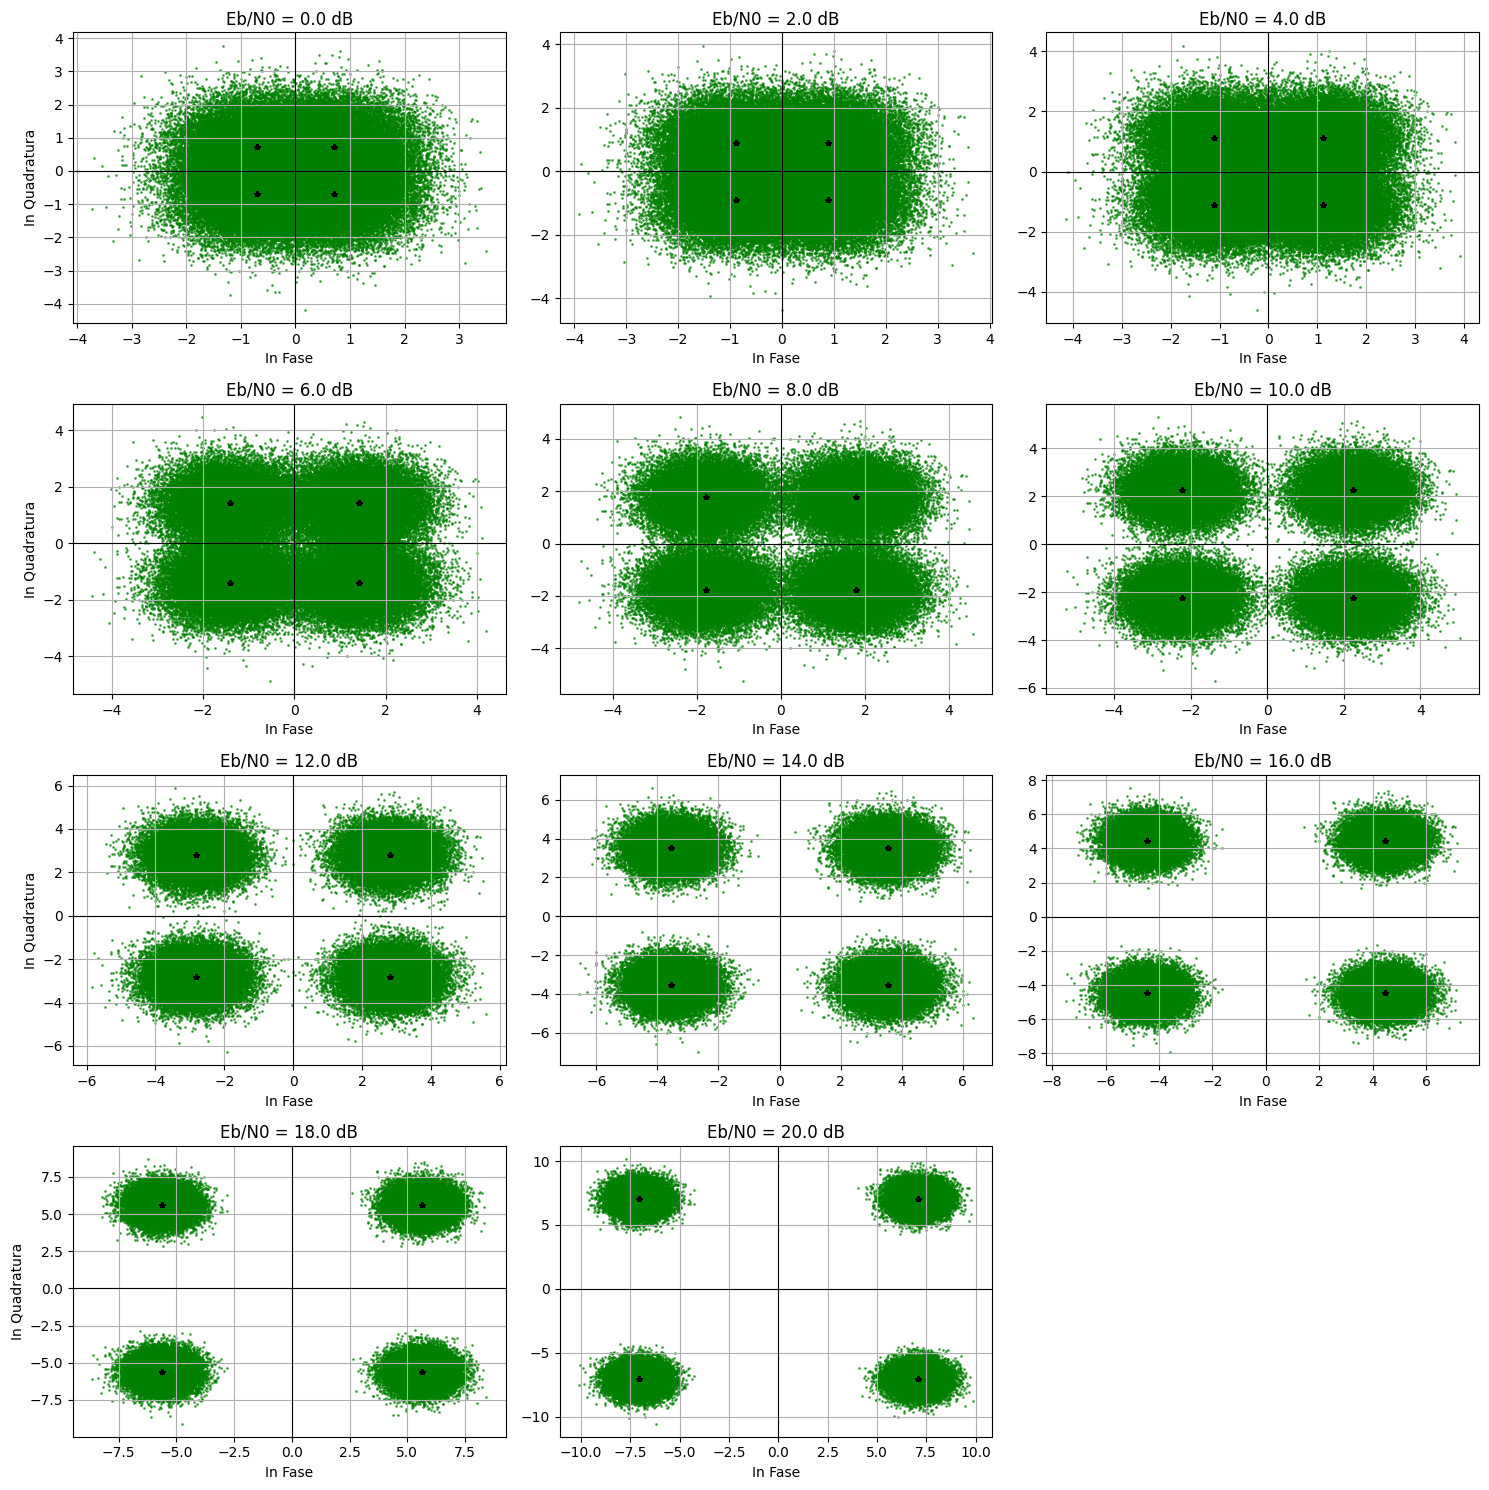

In [ ]:


# Creazione dei subplot
fig, axes = plt.subplots(rows, cols, figsize=(15, 15),constrained_layout=True)
axes = axes.flatten()  # Array 1D per iterare facilmente sugli assi

# Plot per ciascun valore di Eb/N0
for p in range(len(Eb_N0)):
    sig = A[p] * np.sqrt(T) * xi_seq  # Segnale trasmesso
    sig_rx = sig + noise        # Segnale ricevuto  #sig_rx = sig + noise[p, :]        # Segnale ricevuto

    # Scatter plot nel subplot corrispondente
    ax = axes[p]
    ax.scatter(sig_rx.real, sig_rx.imag, color='green', s=1, label='Ricevuto', alpha=0.6)
    ax.scatter(sig.real, sig.imag, color='black', marker='*', s=10, label='Trasmettitore')

    ax.axhline(0, color='k', linewidth=0.8)
    ax.axvline(0, color='k', linewidth=0.8)
    ax.set_title(f'Eb/N0 = {Eb_N0_dB[p]:.1f} dB')
    ax.set_xlabel('In Fase')
    # ax.set_xlim([-5, 5])
    # ax.set_ylim([-5, 5])
    ax.grid(True)
    if p % cols == 0:  # Etichetta asse y solo nella prima colonna
        ax.set_ylabel('In Quadratura')

# Rimuovere eventuali subplot vuoti
for i in range(len(Eb_N0), len(axes)):
    fig.delaxes(axes[i])

# Layout e visualizzazione
plt.tight_layout()
plt.show()


Aumentando l'energia, l'errore diminuisce

# 2. Simulazione Monte-Carlo


## 2.0 classica

In [ ]:
import time

# Parametri
P_e = np.zeros(len(Eb_N0))  # Inizializzazione della probabilità di errore a 0 = 11 elementi
Appoggio = np.zeros(K, dtype = complex)  # Inizializzazione array complesso
num_prove = int(1e2)            # Numero di prove = 100



The time of execution of above program is : 778040.8749580383ms


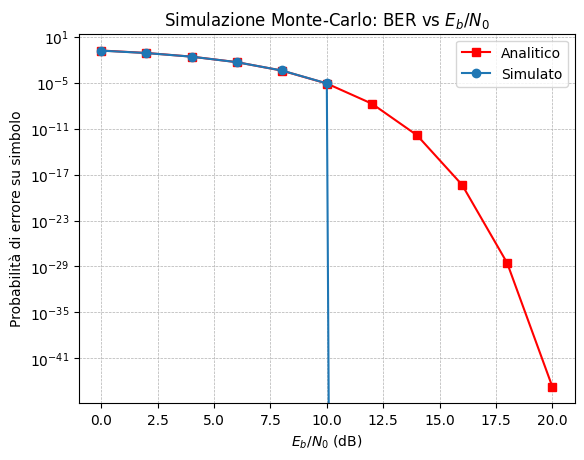

In [ ]:

# record start time
start = time.time()


# Simulazione Monte-Carlo
# testa 100 volte la rice-trasmissione per ognuno degli 11 Eb_N0
for num in range(int(num_prove)):
    xi_seq_hat = np.zeros(K, dtype = complex)
    for p in range(len(Eb_N0)):

        xi_seq = 1 / np.sqrt(2) * (np.random.choice([-1, 1], K) + 1j * np.random.choice([-1, 1], K))  # Costellazione QPSK

        # Trasmettitore
        sig = A[p] * np.sqrt(T) * xi_seq                # Segnale trasmesso: 1 segnale lungo 100mila

        # AWGN (Additive White Gaussian Noise)
        noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part  #noise = np.sqrt(N0[:, None] / 2) * (np.random.randn(len(Eb_N0), K) + 1j * np.random.randn(len(Eb_N0), K))  # AWGN
        sig_rx = sig + noise                               # Segnale ricevuto

        # Ricevitore
        for idx in range(K):        # Loop su ogni campione del segnale ricevuto
            real_part = np.real(sig_rx[idx])
            imag_part = np.imag(sig_rx[idx])  # Funzione per determinare il quadrante e assegnare il valore
            if real_part > 0 and imag_part > 0:
                xi_seq_hat[idx] = 1 / np.sqrt(2) * (1 + 1j)
            elif real_part < 0 and imag_part > 0:
                xi_seq_hat[idx] = 1 / np.sqrt(2) * (-1 + 1j)
            elif real_part < 0 and imag_part < 0:
                xi_seq_hat[idx] = 1 / np.sqrt(2) * (-1 - 1j)
            elif real_part > 0 and imag_part < 0:
                xi_seq_hat[idx] = 1 / np.sqrt(2) * (1 - 1j)
            else:
                print(f"Warning: Unhandled case for real={real_part}, imag={imag_part}")
                xi_seq_hat[idx] = 0  # Default case

        # Calcolo della probabilità d'errore sul simbolo (SEP)
        P_e[p] += np.sum(xi_seq != xi_seq_hat) / K # Memorizzo il SEP per ogni Eb_N0
        #es) alla 100esima prova, P_e[0] conterrà la somma di 100 SEP ottenute dalle simulazioni ad 1dB




# Calcolo SEP medio su tutte le 100 prove
P_e = P_e / num_prove # Divido ciascun elemento di P_e[] per 100
#così avrò 11 elementi che rappresentano la SEP media su 100 prove per quella specifica Eb_N0
#es) in P_e[10] avrò la SEP media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=100 cioè 20dB
#es) in P_e[5] avrò la SEP media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=10 cioè 10dB


# Calcolo della probabilità teorica
P_e_theoretical = erfc(np.sqrt(Eb / N0))

# record end time
end = time.time()





# print the difference between start and end time in milli. secs
print(f"The time of execution of above program is : {(end-start) * 10**3}ms")


# Plot dei risultati
plt.figure()
plt.semilogy(Eb_N0_dB, P_e_theoretical, '-sr', label='Analitico')  # Risultati teorici
plt.semilogy(Eb_N0_dB, P_e, '-o', label='Simulato')  # Risultati simulati
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Probabilità di errore su simbolo') # in questo caso simbolo=bit
plt.legend()
plt.title('Simulazione Monte-Carlo: BER vs $E_b/N_0$')
plt.show()

# La simulazione si interrompe perché non riesce più a trovare errori: numero di prove insufficiente
#The time of execution of above program is : 778040.8749580383ms


La simulazione si interrompe perché non riesce più a trovare errori: numero di prove insufficiente

## 2.1 Usando calcoli paralleli

In [7]:
import threading
!pip install multiprocess
from multiprocess import Array

# Parametri
P_e = np.zeros(len(Eb_N0))  # Inizializzazione della probabilità di errore a 0 = 11 elementi
num_prove = int(1e2)            # Numero di prove = 100
arr = Array('d', [0] * len(Eb_N0))


The time of execution of above program is : 809116.5933609009ms


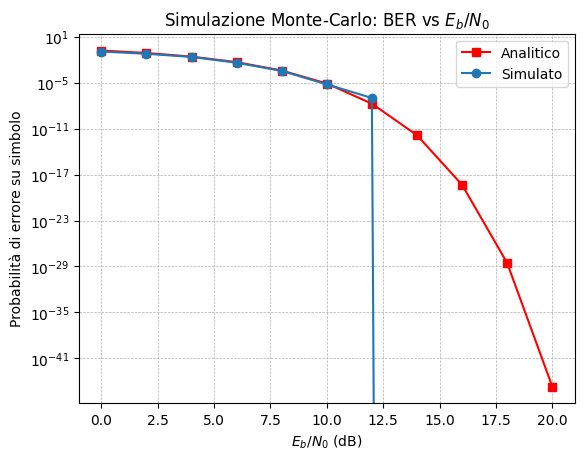

In [8]:

def simulate_rice_transmission(temp):
    xi_seq_hat = np.zeros(K, dtype = complex)
    # per ognuno degli 11 Eb_N0
    for p in range(len(Eb_N0)):

        xi_seq = 1 / np.sqrt(2) * (np.random.choice([-1, 1], K) + 1j * np.random.choice([-1, 1], K))  # Costellazione QPSK

        # Trasmettitore
        sig = A[p] * np.sqrt(T) * xi_seq                # Segnale trasmesso: 1 segnale lungo 100mila

        # AWGN (Additive White Gaussian Noise)
        noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part  #noise = np.sqrt(N0[:, None] / 2) * (np.random.randn(len(Eb_N0), K) + 1j * np.random.randn(len(Eb_N0), K))  # AWGN
        sig_rx = sig + noise                               # Segnale ricevuto


        # Ricevitore
        for idx in range(K):        # Loop su ogni campione del segnale ricevuto
            real_part = np.real(sig_rx[idx])
            imag_part = np.imag(sig_rx[idx])  # Funzione per determinare il quadrante e assegnare il valore
            if real_part > 0 and imag_part > 0:
                xi_seq_hat[idx] = 1 / np.sqrt(2) * (1 + 1j)
            elif real_part < 0 and imag_part > 0:
                xi_seq_hat[idx] = 1 / np.sqrt(2) * (-1 + 1j)
            elif real_part < 0 and imag_part < 0:
                xi_seq_hat[idx] = 1 / np.sqrt(2) * (-1 - 1j)
            elif real_part > 0 and imag_part < 0:
                xi_seq_hat[idx] = 1 / np.sqrt(2) * (1 - 1j)
            else:
                print(f"Warning: Unhandled case for real={real_part}, imag={imag_part}")
                xi_seq_hat[idx] = 0  # Default case

        # Calcolo della probabilità d'errore sul simbolo (SEP)
        temp[p] += np.sum(xi_seq != xi_seq_hat) / K # Memorizzo il SEP per ogni Eb_N0
        #es) alla 100esima prova, P_e[0] conterrà la somma di 100 SEP ottenute dalle simulazioni ad 1dB




# record start time
start = time.time()


# Simulazione Monte-Carlo
# testa 100 volte la rice-trasmissione per ognuno degli 11 Eb_N0
for num in range(int(num_prove)):
  #avvia 100 thread
  t1 = threading.Thread(target=simulate_rice_transmission, args=(arr,))
  t1.start()


for num in range(int(num_prove)):
  #attendi la terminazione di 100 thread
  t1.join()



# Calcolo SEP medio su tutte le 100 prove
P_e = np.frombuffer(arr.get_obj(), dtype=np.float64) / num_prove # Divido ciascun elemento di P_e[] per 100
#così avrò 11 elementi che rappresentano la SEP media su 100 prove per quella specifica Eb_N0
#es) in P_e[10] avrò la SEP media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=100 cioè 20dB
#es) in P_e[5] avrò la SEP media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=10 cioè 10dB


# Calcolo della probabilità teorica
P_e_theoretical = erfc(np.sqrt(Eb / N0))

# record end time
end = time.time()







# print the difference between start and end time in milli. secs
print(f"The time of execution of above program is : {(end-start) * 10**3}ms")


# Plot dei risultati
plt.figure()
plt.semilogy(Eb_N0_dB, P_e_theoretical, '-sr', label='Analitico')  # Risultati teorici
plt.semilogy(Eb_N0_dB, P_e, '-o', label='Simulato')  # Risultati simulati
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Probabilità di errore su simbolo') # in questo caso simbolo=bit
plt.legend()
plt.title('Simulazione Monte-Carlo: BER vs $E_b/N_0$')
plt.show()

# La simulazione si interrompe perché non riesce più a trovare errori: numero di prove insufficiente
#The time of execution of above program is : 809116.5933609009ms


link utili:


*   Documentazione Shared Memory Array della libreria multiprocessing: https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Array
*   Thread della libreria threading: https://www.geeksforgeeks.org/multithreading-python-set-1/



# 3 Simulazione Monte-Carlo con ottimizzazioni

## 3.0 classica

In [3]:
import time

# Parametri
P_e = np.zeros(len(Eb_N0))  # Inizializzazione della probabilità di errore a 0 = 11 elementi
Appoggio = np.zeros(K, dtype = complex)  # Inizializzazione array complesso
num_prove = int(1e2)            # Numero di prove = 100



The time of execution of above program is : 15294.195413589478ms


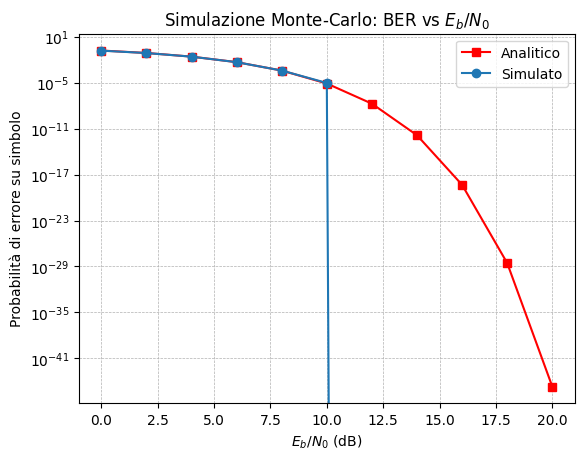

In [4]:

# record start time
start = time.time()


# Simulazione Monte-Carlo
# testa 100 volte la rice-trasmissione per ognuno degli 11 Eb_N0
for num in range(int(num_prove)):
    xi_seq_hat = np.zeros(K, dtype = complex)
    for p in range(len(Eb_N0)):

        xi_seq = 1 / np.sqrt(2) * (np.random.choice([-1, 1], K) + 1j * np.random.choice([-1, 1], K))  # Costellazione QPSK

        # Trasmettitore
        sig = A[p] * np.sqrt(T) * xi_seq                # Segnale trasmesso: 1 segnale lungo 100mila

        # AWGN (Additive White Gaussian Noise)
        noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part  #noise = np.sqrt(N0[:, None] / 2) * (np.random.randn(len(Eb_N0), K) + 1j * np.random.randn(len(Eb_N0), K))  # AWGN
        sig_rx = sig + noise                               # Segnale ricevuto

        # Ricevitore
        real_part = np.real(sig_rx)
        imag_part = np.imag(sig_rx)

        mask_q1 = (real_part > 0) & (imag_part > 0)        # Quadrante 1 (Re > 0, Im > 0)
        xi_seq_hat[mask_q1] = 1 / np.sqrt(2) * (1 + 1j)

        mask_q2 = (real_part < 0) & (imag_part > 0)        # Quadrante 2 (Re < 0, Im > 0)
        xi_seq_hat[mask_q2] = 1 / np.sqrt(2) * (-1 + 1j)

        mask_q3 = (real_part < 0) & (imag_part < 0)        # Quadrante 3 (Re < 0, Im < 0)
        xi_seq_hat[mask_q3] = 1 / np.sqrt(2) * (-1 - 1j)

        mask_q4 = (real_part > 0) & (imag_part < 0)        # Quadrante 4 (Re > 0, Im < 0)
        xi_seq_hat[mask_q4] = 1 / np.sqrt(2) * (1 - 1j)

        # Verifica di eventuali valori non classificati (opzionale)
        unhandled_mask = ~(mask_q1 | mask_q2 | mask_q3 | mask_q4)
        if np.any(unhandled_mask):
            print(f"Warning: Unhandled cases for indices {np.where(unhandled_mask)}")
            xi_seq_hat[unhandled_mask] = 0  # Default case

        # Calcolo della probabilità d'errore sul simbolo (SEP)
        P_e[p] += np.sum(xi_seq != xi_seq_hat) / K # Memorizzo il SEP per ogni Eb_N0
        #es) alla 100esima prova, P_e[0] conterrà la somma di 100 SEP ottenute dalle simulazioni ad 1dB




# Calcolo SEP medio su tutte le 100 prove
P_e = P_e / num_prove # Divido ciascun elemento di P_e[] per 100
#così avrò 11 elementi che rappresentano la SEP media su 100 prove per quella specifica Eb_N0
#es) in P_e[10] avrò la SEP media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=100 cioè 20dB
#es) in P_e[5] avrò la SEP media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=10 cioè 10dB


# Calcolo della probabilità teorica
P_e_theoretical = erfc(np.sqrt(Eb / N0))

# record end time
end = time.time()





# print the difference between start and end time in milli. secs
print(f"The time of execution of above program is : {(end-start) * 10**3}ms")


# Plot dei risultati
plt.figure()
plt.semilogy(Eb_N0_dB, P_e_theoretical, '-sr', label='Analitico')  # Risultati teorici
plt.semilogy(Eb_N0_dB, P_e, '-o', label='Simulato')  # Risultati simulati
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Probabilità di errore su simbolo') # in questo caso simbolo=bit
plt.legend()
plt.title('Simulazione Monte-Carlo: BER vs $E_b/N_0$')
plt.show()

# La simulazione si interrompe perché non riesce più a trovare errori: numero di prove insufficiente
#The time of execution of above program is : 778040.8749580383ms


La simulazione si interrompe perché non riesce più a trovare errori: numero di prove insufficiente

## 3.1 Usando calcoli paralleli

In [5]:
import threading
!pip install multiprocess
from multiprocess import Array

# Parametri
P_e = np.zeros(len(Eb_N0))  # Inizializzazione della probabilità di errore a 0 = 11 elementi
num_prove = int(1e2)            # Numero di prove = 100
arr = Array('d', [0] * len(Eb_N0))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.1 MB/s eta 0:00:00


The time of execution of above program is : 20761.380434036255ms


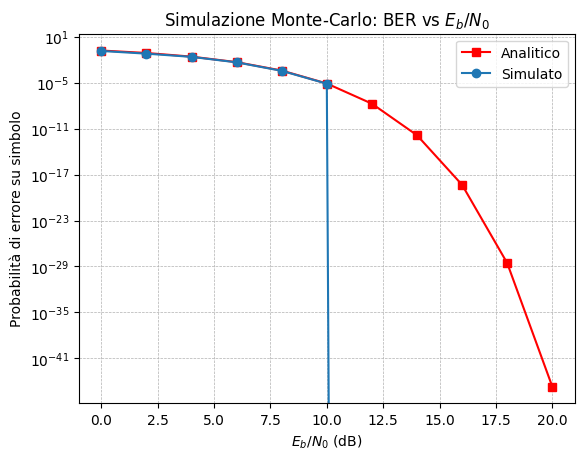

In [6]:

def simulate_rice_transmission(temp):
    xi_seq_hat = np.zeros(K, dtype = complex)
    # per ognuno degli 11 Eb_N0
    for p in range(len(Eb_N0)):

        xi_seq = 1 / np.sqrt(2) * (np.random.choice([-1, 1], K) + 1j * np.random.choice([-1, 1], K))  # Costellazione QPSK

        # Trasmettitore
        sig = A[p] * np.sqrt(T) * xi_seq                # Segnale trasmesso: 1 segnale lungo 100mila

        # AWGN (Additive White Gaussian Noise)
        noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part  #noise = np.sqrt(N0[:, None] / 2) * (np.random.randn(len(Eb_N0), K) + 1j * np.random.randn(len(Eb_N0), K))  # AWGN
        sig_rx = sig + noise                               # Segnale ricevuto


        # Ricevitore
        real_part = np.real(sig_rx)
        imag_part = np.imag(sig_rx)

        mask_q1 = (real_part > 0) & (imag_part > 0)        # Quadrante 1 (Re > 0, Im > 0)
        xi_seq_hat[mask_q1] = 1 / np.sqrt(2) * (1 + 1j)

        mask_q2 = (real_part < 0) & (imag_part > 0)        # Quadrante 2 (Re < 0, Im > 0)
        xi_seq_hat[mask_q2] = 1 / np.sqrt(2) * (-1 + 1j)

        mask_q3 = (real_part < 0) & (imag_part < 0)        # Quadrante 3 (Re < 0, Im < 0)
        xi_seq_hat[mask_q3] = 1 / np.sqrt(2) * (-1 - 1j)

        mask_q4 = (real_part > 0) & (imag_part < 0)        # Quadrante 4 (Re > 0, Im < 0)
        xi_seq_hat[mask_q4] = 1 / np.sqrt(2) * (1 - 1j)

        # Verifica di eventuali valori non classificati (opzionale)
        unhandled_mask = ~(mask_q1 | mask_q2 | mask_q3 | mask_q4)
        if np.any(unhandled_mask):
            print(f"Warning: Unhandled cases for indices {np.where(unhandled_mask)}")
            xi_seq_hat[unhandled_mask] = 0  # Default case


        # Calcolo della probabilità d'errore sul simbolo (SEP)
        temp[p] += np.sum(xi_seq != xi_seq_hat) / K # Memorizzo il SEP per ogni Eb_N0
        #es) alla 100esima prova, P_e[0] conterrà la somma di 100 SEP ottenute dalle simulazioni ad 1dB




# record start time
start = time.time()


# Simulazione Monte-Carlo
# testa 100 volte la rice-trasmissione per ognuno degli 11 Eb_N0
for num in range(int(num_prove)):
  #avvia 100 thread
  t1 = threading.Thread(target=simulate_rice_transmission, args=(arr,))
  t1.start()


for num in range(int(num_prove)):
  #attendi la terminazione di 100 thread
  t1.join()



# Calcolo SEP medio su tutte le 100 prove
P_e = np.frombuffer(arr.get_obj(), dtype=np.float64) / num_prove # Divido ciascun elemento di P_e[] per 100
#così avrò 11 elementi che rappresentano la SEP media su 100 prove per quella specifica Eb_N0
#es) in P_e[10] avrò la SEP media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=100 cioè 20dB
#es) in P_e[5] avrò la SEP media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=10 cioè 10dB


# Calcolo della probabilità teorica
P_e_theoretical = erfc(np.sqrt(Eb / N0))

# record end time
end = time.time()







# print the difference between start and end time in milli. secs
print(f"The time of execution of above program is : {(end-start) * 10**3}ms")


# Plot dei risultati
plt.figure()
plt.semilogy(Eb_N0_dB, P_e_theoretical, '-sr', label='Analitico')  # Risultati teorici
plt.semilogy(Eb_N0_dB, P_e, '-o', label='Simulato')  # Risultati simulati
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Probabilità di errore su simbolo') # in questo caso simbolo=bit
plt.legend()
plt.title('Simulazione Monte-Carlo: BER vs $E_b/N_0$')
plt.show()

# La simulazione si interrompe perché non riesce più a trovare errori: numero di prove insufficiente
#The time of execution of above program is : 20126.314401626587ms


link utili:


*   Documentazione Shared Memory Array della libreria multiprocessing: https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Array
*   Thread della libreria threading: https://www.geeksforgeeks.org/multithreading-python-set-1/



# 4. Decisore con Intelligenza Artificiale: DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

In [ ]:
### preparazione dei dati per l'addestramento della rete

### Costellazione
xi_seq = 1 / np.sqrt(2) * (np.random.choice([-1, 1], K) + 1j * np.random.choice([-1, 1], K))  # Costellazione QPSK
noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part  #noise = np.sqrt(N0[:, None] / 2) * (np.random.randn(len(Eb_N0), K) + 1j * np.random.randn(len(Eb_N0), K))  # AWGN
Y = np.zeros(K)  # Inizializzazione array complesso

for idx in range(K):        # Loop su ogni campione del segnale ricevuto
  real_part = np.real(xi_seq[idx])
  imag_part = np.imag(xi_seq[idx])  # Funzione per determinare il quadrante e assegnare il valore
  if real_part > 0 and imag_part > 0:
      Y[idx] = 1
  elif real_part < 0 and imag_part > 0:
      Y[idx] = 2
  elif real_part < 0 and imag_part < 0:
      Y[idx] = 3
  elif real_part > 0 and imag_part < 0:
      Y[idx] = 4
  else:
      print(f"Warning: Unhandled case for real={real_part}, imag={imag_part}")
      Y[idx] = 0  # Default case

print(Y,xi_seq)

sig = A[10] * np.sqrt(T) * xi_seq  # Segnale trasmesso = 100mila elementi (la dipendenza da Eb_N0 sta nella A)
sig_rx = sig + noise              # Segnale ricevuto = 100mila elementi: ciascun bit è stato affetto da un AWGN


### Addestramento della rete

# dati di input
X_real_imag = np.column_stack((np.real(sig_rx), np.imag(sig_rx)))

# dati che vorrei che il modello imparasse a dare in output
Y_quadranti = Y.copy()

# training della rete
model.fit(X_real_imag,Y_quadranti)


[4. 4. 4. ... 2. 3. 4.] [ 0.70710678-0.70710678j  0.70710678-0.70710678j  0.70710678-0.70710678j
 ... -0.70710678+0.70710678j -0.70710678-0.70710678j
  0.70710678-0.70710678j]


DecisionTreeClassifier()

visualizziamo quale è il criterio di decisione che ha appreso il modello

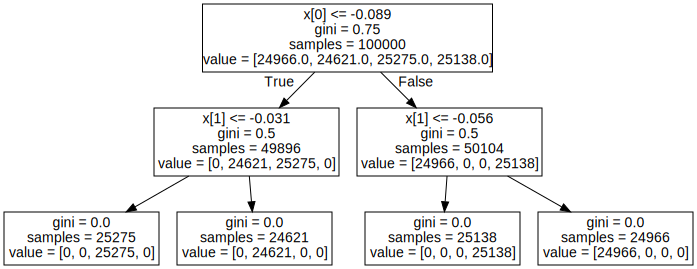

In [ ]:
from graphviz import Source
from sklearn import tree
from IPython.display import SVG

graph = Source( tree.export_graphviz(model, out_file=None))
SVG(graph.pipe(format='svg'))


In [ ]:
### Test della rete come Decisore su 3 singoli valori a scelta da predire

valore_da_predire = [[-0.3,1],[0.4,-2],[-0.1,-3]] #2° quadrante, 4°quadrante, 3° quadrante

# Crea un array NumPy contenente il valore da predire
input_value = np.array([valore_da_predire])

# Ridimensiona l'array per adattarlo al modello (come fatto durante l'addestramento)
input_value = input_value.reshape(3, -1)  # 3 perchè sono 3 valori da predire

# Esegui la predizione
prediction = model.predict(input_value)

# Stampa la predizione
print(prediction)

[2. 4. 3.]


utilizziamo la rete come Decisore nella Simulazione con metodo Monte-Carlo

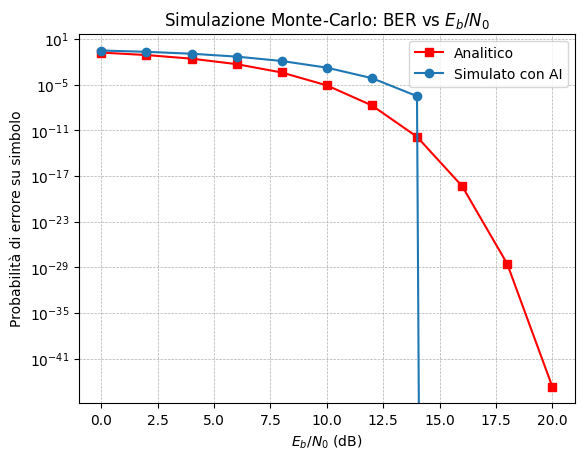

In [ ]:

# Parametri
P_e = np.zeros(len(Eb_N0))  # Inizializzazione della probabilità di errore a 0 = 11 elementi
Appoggio = np.zeros(K)  # Inizializzazione array complesso
num_prove = int(1e2)            # Numero di prove = 100


# Simulazione Monte-Carlo
# testa 100 volte la rice-trasmissione per ognuno degli 11 Eb_N0
for num in range(int(num_prove)):
    xi_seq_hat = np.zeros(K, dtype = complex)
    for p in range(len(Eb_N0)):

        xi_seq = 1 / np.sqrt(2) * (np.random.choice([-1, 1], K) + 1j * np.random.choice([-1, 1], K))  # Costellazione QPSK

        # Trasmettitore
        sig = A[p] * np.sqrt(T) * xi_seq                # Segnale trasmesso: 1 segnale lungo 100mila

        # AWGN (Additive White Gaussian Noise)
        noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part  #noise = np.sqrt(N0[:, None] / 2) * (np.random.randn(len(Eb_N0), K) + 1j * np.random.randn(len(Eb_N0), K))  # AWGN
        sig_rx = sig + noise                               # Segnale ricevuto
        sig_rx_real_imag = np.column_stack((np.real(sig_rx), np.imag(sig_rx)))


        # Ricevitore
        Appoggio = (model.predict(sig_rx_real_imag.reshape(100000, -1)))                 # Decisione del ricevitore: dato che l'output è -1 se <0 e 1 se >0, allora deve restituire True quando è -1 e False quando è 1
        for idx in range(K):        # Loop su ogni campione del segnale ricevuto
          if Appoggio[idx] == 1:  # Quadrante 1
              xi_seq_hat[idx] = 1 / np.sqrt(2) * (1 + 1j)
          elif Appoggio[idx] == 2:  # Quadrante 2
              xi_seq_hat[idx] = 1 / np.sqrt(2) * (-1 + 1j)
          elif Appoggio[idx] == 3:  # Quadrante 3
              xi_seq_hat[idx] = 1 / np.sqrt(2) * (-1 - 1j)
          elif Appoggio[idx] == 4:  # Quadrante 4
              xi_seq_hat[idx] = 1 / np.sqrt(2) * (1 - 1j)
          else:
              xi_seq_hat[idx] = 0  # Fallback (mai dovresti arrivare qui)

        # Calcolo della probabilità d'errore sul bit (BER)
        P_e[p] += np.sum(xi_seq != xi_seq_hat) / K # Memorizzo il BER per ogni Eb_N0
        #es) alla 100esima prova, P_e[0] conterrà la somma di 100 BER ottenute dalle simulazioni ad 1dB



# Calcolo BER medio su tutte le 100 prove
P_e = P_e / num_prove # Divido ciascun elemento di P_e[] per 100
#così avrò 11 elementi che rappresentano la BER media su 100 prove per quella specifica Eb_N0
#es) in P_e[10] avrò la BER media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=100 cioè 20dB
#es) in P_e[5] avrò la BER media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=10 cioè 10dB


# Calcolo della probabilità teorica
P_e_theoretical = erfc(np.sqrt(Eb / N0))



# Plot dei risultati
plt.figure()
plt.semilogy(Eb_N0_dB, P_e_theoretical, '-sr', label='Analitico')  # Risultati teorici
plt.semilogy(Eb_N0_dB, P_e, '-o', label='Simulato con AI')  # Risultati simulati
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Probabilità di errore su simbolo') # in questo caso simbolo=bit
plt.legend()
plt.title('Simulazione Monte-Carlo: BER vs $E_b/N_0$')
plt.show()

# La simulazione si interrompe perché non riesce più a trovare errori: numero di prove insufficiente

link utili:


*  https://www.youtube.com/watch?v=7eh4d6sabA0&ab_channel=ProgrammingwithMosh
*   https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn
*   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.fit





# 5. Decisore con Intelligenza Artificiale: Stochastic Gradient Descent Classifier

rispetto ad un DecisionTreeClassifier ho il vantaggio di poter addestrare la rete su più epoche e quindi rendere il modello più robusto. Ogni epoca è rappresentata da un contrasto di energia sempre crescente

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import numpy as np

### Costellazione
xi_seq = 1 / np.sqrt(2) * (np.random.choice([-1, 1], K) + 1j * np.random.choice([-1, 1], K))  # Costellazione QPSK
Y = np.zeros(K)  # Inizializzazione array complesso

for idx in range(K):        # Loop su ogni campione del segnale ricevuto
  real_part = np.real(xi_seq[idx])
  imag_part = np.imag(xi_seq[idx])  # Funzione per determinare il quadrante e assegnare il valore
  if real_part > 0 and imag_part > 0:
      Y[idx] = 1
  elif real_part < 0 and imag_part > 0:
      Y[idx] = 2
  elif real_part < 0 and imag_part < 0:
      Y[idx] = 3
  elif real_part > 0 and imag_part < 0:
      Y[idx] = 4
  else:
      print(f"Warning: Unhandled case for real={real_part}, imag={imag_part}")
      Y[idx] = 0  # Default case

print(Y,xi_seq)


# Inizializzazione del modello con warm_start=True
clf = SGDClassifier(loss="hinge", max_iter=1000, warm_start=True, random_state=42, verbose=True, alpha=0.0002, learning_rate="adaptive",eta0=1)
for i in range(5):
  for p in range(len(Eb_N0)):  # Simula 11 epoche

    sig = A[p] * np.sqrt(T) * xi_seq  # Segnale trasmesso = 100mila elementi (la dipendenza da Eb_N0 sta nella A)
    noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part  #noise = np.sqrt(N0[:, None] / 2) * (np.random.randn(len(Eb_N0), K) + 1j * np.random.randn(len(Eb_N0), K))  # AWGN
    sig_rx = sig + noise              # Segnale ricevuto = 100mila elementi: ciascun bit è stato affetto da un AWGN


    ### Addestramento della rete

    # dati di input
    X_real_imag = np.column_stack((np.real(sig_rx), np.imag(sig_rx)))

    # dati che vorrei che il modello imparasse a dare in output
    Y_quadranti = Y.copy()


    clf.fit(X_real_imag, Y_quadranti)  # Addestra ulteriormente sul dataset intero
    y_pred = clf.predict(X_real_imag)
    #print(f"Epoca {p + 1}: Accuracy = {accuracy_score(Y_quadranti, y_pred)}")


Streaming output truncated to the last 5000 lines.
Total training time: 0.51 seconds.
-- Epoch 45
Norm: 3.17, NNZs: 2, Bias: -4.911531, T: 4500000, Avg. loss: 0.039862
Total training time: 0.52 seconds.
-- Epoch 46
Norm: 3.17, NNZs: 2, Bias: -4.911582, T: 4600000, Avg. loss: 0.039861
Total training time: 0.53 seconds.
-- Epoch 47
Norm: 3.17, NNZs: 2, Bias: -4.911595, T: 4700000, Avg. loss: 0.039862
Total training time: 0.54 seconds.
-- Epoch 48
Norm: 3.17, NNZs: 2, Bias: -4.911590, T: 4800000, Avg. loss: 0.039860
Total training time: 0.56 seconds.
-- Epoch 49
Norm: 3.17, NNZs: 2, Bias: -4.911585, T: 4900000, Avg. loss: 0.039860
Total training time: 0.57 seconds.
-- Epoch 50
Norm: 3.17, NNZs: 2, Bias: -4.911577, T: 5000000, Avg. loss: 0.039860
Total training time: 0.58 seconds.
-- Epoch 51
Norm: 3.17, NNZs: 2, Bias: -4.911567, T: 5100000, Avg. loss: 0.039860
Total training time: 0.59 seconds.
-- Epoch 52
Norm: 3.17, NNZs: 2, Bias: -4.911554, T: 5200000, Avg. loss: 0.039860
Total trainin

In [ ]:
### Test della rete come Decisore su 3 singoli valori a scelta da predire

valore_da_predire = [[-0.3,1],[0.4,-2.7],[-0.1,-3.33]] #2° quadrante, 4°quadrante, 3° quadrante

# Crea un array NumPy contenente il valore da predire
input_value = np.array([valore_da_predire])

# Ridimensiona l'array per adattarlo al modello (come fatto durante l'addestramento)
input_value = input_value.reshape(3, -1)  # 3 perchè sono 3 valori da predire

# Esegui la predizione
prediction = clf.predict(input_value)

# Stampa la predizione
print(prediction)


[2. 4. 3.]


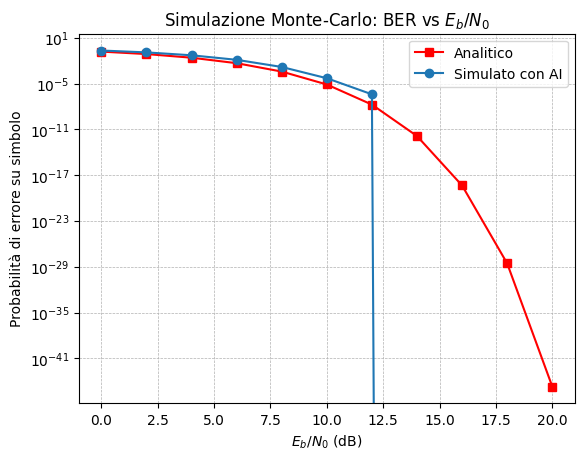

In [ ]:

# Parametri
P_e = np.zeros(len(Eb_N0))  # Inizializzazione della probabilità di errore a 0 = 11 elementi
Appoggio = np.zeros(K)  # Inizializzazione array complesso
num_prove = int(1e2)            # Numero di prove = 100


# Simulazione Monte-Carlo
# testa 100 volte la rice-trasmissione per ognuno degli 11 Eb_N0
for num in range(int(num_prove)):
    xi_seq_hat = np.zeros(K, dtype = complex)
    for p in range(len(Eb_N0)):

        xi_seq = 1 / np.sqrt(2) * (np.random.choice([-1, 1], K) + 1j * np.random.choice([-1, 1], K))  # Costellazione QPSK

        # Trasmettitore
        sig = A[p] * np.sqrt(T) * xi_seq                # Segnale trasmesso: 1 segnale lungo 100mila

        # AWGN (Additive White Gaussian Noise)
        noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part  #noise = np.sqrt(N0[:, None] / 2) * (np.random.randn(len(Eb_N0), K) + 1j * np.random.randn(len(Eb_N0), K))  # AWGN
        sig_rx = sig + noise                               # Segnale ricevuto
        sig_rx_real_imag = np.column_stack((np.real(sig_rx), np.imag(sig_rx)))


        # Ricevitore
        Appoggio = (clf.predict(sig_rx_real_imag.reshape(100000, -1)))                 # Decisione del ricevitore: dato che l'output è -1 se <0 e 1 se >0, allora deve restituire True quando è -1 e False quando è 1
        for idx in range(K):        # Loop su ogni campione del segnale ricevuto
          if Appoggio[idx] == 1:  # Quadrante 1
              xi_seq_hat[idx] = 1 / np.sqrt(2) * (1 + 1j)
          elif Appoggio[idx] == 2:  # Quadrante 2
              xi_seq_hat[idx] = 1 / np.sqrt(2) * (-1 + 1j)
          elif Appoggio[idx] == 3:  # Quadrante 3
              xi_seq_hat[idx] = 1 / np.sqrt(2) * (-1 - 1j)
          elif Appoggio[idx] == 4:  # Quadrante 4
              xi_seq_hat[idx] = 1 / np.sqrt(2) * (1 - 1j)
          else:
              xi_seq_hat[idx] = 0  # Fallback (mai dovresti arrivare qui)

        # Calcolo della probabilità d'errore sul bit (BER)
        P_e[p] += np.sum(xi_seq != xi_seq_hat) / K # Memorizzo il BER per ogni Eb_N0
        #es) alla 100esima prova, P_e[0] conterrà la somma di 100 BER ottenute dalle simulazioni ad 1dB



# Calcolo BER medio su tutte le 100 prove
P_e = P_e / num_prove # Divido ciascun elemento di P_e[] per 100
#così avrò 11 elementi che rappresentano la BER media su 100 prove per quella specifica Eb_N0
#es) in P_e[10] avrò la BER media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=100 cioè 20dB
#es) in P_e[5] avrò la BER media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=10 cioè 10dB


# Calcolo della probabilità teorica
P_e_theoretical = erfc(np.sqrt(Eb / N0))



# Plot dei risultati
plt.figure()
plt.semilogy(Eb_N0_dB, P_e_theoretical, '-sr', label='Analitico')  # Risultati teorici
plt.semilogy(Eb_N0_dB, P_e, '-o', label='Simulato con AI')  # Risultati simulati
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Probabilità di errore su simbolo') # in questo caso simbolo=bit
plt.legend()
plt.title('Simulazione Monte-Carlo: BER vs $E_b/N_0$')
plt.show()

# La simulazione si interrompe perché non riesce più a trovare errori: numero di prove insufficiente

#9min e 41s

link utili:


*   visualizzare un SGD: https://www.youtube.com/watch?v=_YPScrckx28&ab_channel=VisuallyExplained
*   perchè un SGD funziona bene: https://www.youtube.com/watch?v=UmathvAKj80&ab_channel=VisuallyExplained

